## Table of contents
### - [Introduction](#Introduction)
### - [Setup](#Setup)
### - [Example image](#Example-image)
### - [Automatic mask generation](#Automatic-mask-generation)
### - [Automatic mask generation options](#Automatic-mask-generation-options)
### - [Classification model](#Classification-model)
### - [Inference](#Inference)
### - [Gradio app](#Gradio-app)
### - [References](#References)
### - [Limitations](#Limitations)

## Introduction

In this notebook, I will combine Meta's segmentation model called **`SAM`** (Segment Anything Model) with a pretrained image classification model from the timm library to create a simple Gradio app. This app will categorize the objects found in an input image.

A significant portion of the code and explanations presented here has been replicated and adapted from the sources detailed in the [References](#References) section.

The purpose of this modest project is solely to experiment, learn, and practice.

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install gradio

!mkdir images
!wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_4b8939.pth

PyTorch version: 2.0.0
Torchvision version: 0.15.1
CUDA is available: True
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 56.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.2/294.2 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 7.0 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.1-py3-none-any.whl size=5596 sha256=43ba6f012887ffe5513e62f9216526b2e96e2e4f1b81766dcd31a5e69e603fc0
  Stored in directory: /root/.cache/pip/wheels/01/a6/d1/1c0828c304a4283b2c1639a09ad86f83d7c487ef34c6b4a1bf
Successfully built ffmpy
  Attempting uninstall: mdit-py-plugins
    Found existing installation: mdit-py-plugins 0.4.0
    Uninstalling m

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth


In [3]:
image_path = './images/dog.jpg'

In [4]:
sam_model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

(534, 800, 3)


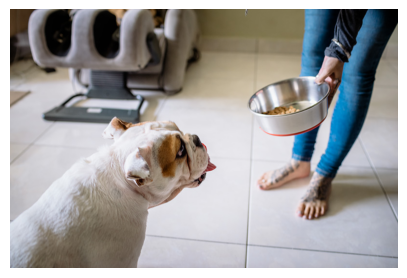

In [6]:
image = Image.open(image_path)
image = np.array(image.convert("RGB"))
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
# import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = sam_model_path
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device);

# mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
# masks = mask_generator.generate(image)

Show all the masks overlayed on the image

In [ ]:
# plt.figure(figsize=(5,5))
# plt.imshow(image)
# show_anns(masks)
# plt.axis('off')
# plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

In [ ]:
masks2[0].keys()

Show all the masks overlayed on the image

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

Show the dog mask in isolation, with dark background

In [ ]:
mask = np.where(masks2[23]['segmentation'], 1, 0)
new_image = image * np.expand_dims(mask, axis=-1)
plt.figure(figsize=(5,5))
plt.imshow(new_image)
plt.axis('off')
plt.show()

Show each mask separately

In [ ]:
# for i in range(len(masks2)):
#     print(i)
#     mask = np.where(masks2[i]['segmentation'], 1, 0)
#     new_image = image * np.expand_dims(mask, axis=-1)
#     plt.figure(figsize=(5,5))
#     plt.imshow(new_image)
#     plt.axis('off')
#     plt.show()

Function to determine whether a mask belongs to a greater one

In [ ]:
def is_part_of(mask1, mask2):
    mask1, mask2 = mask1.flatten(), mask2.flatten()
    # True if mask1 is entirely contained within mask2
    if np.any(mask1 & ~mask2):
        return False
    # True if both masks are NOT identical    
    if np.count_nonzero(mask1)==np.count_nonzero(mask2):
        return False
    return True


# check objects belonging to mask23

for i in range(len(masks2)):
    if is_part_of(masks2[i]['segmentation'], masks2[23]['segmentation']):
        print(f"Mask {i} is part of mask23")


# check if mask21 belongs to another mask

for i in range(len(masks2)):
    if is_part_of(masks2[21]['segmentation'], masks2[i]['segmentation']):
        print(f"Mask 21 is part of mask {i}.")

## Classification model

In [ ]:
# !pip install timm (not necessary in Kaggle)
import timm
# timm.list_models('*huge*in1k*', pretrained=True)

Chose model blablabla because blablabla

In [ ]:
cv_model = timm.create_model('convnext_xxlarge.clip_laion2b_soup_ft_in1k', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(cv_model.pretrained_cfg)
)

transform;

Apply transform to image prior to inference

In [ ]:
pil_image = Image.fromarray(new_image.astype(np.uint8))
image_tensor = transform(pil_image)

Show transformed image

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(image_tensor, (1,2,0)))
show_anns(masks2)
plt.axis('off')
plt.show()

## Inference

In [ ]:
with torch.no_grad():
    output = cv_model(image_tensor.unsqueeze(0))
output.shape

In [ ]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

In [ ]:
values, indices = torch.topk(probabilities, 3)
indices

Obtain labels from the `IMAGENET_1k` dataset

In [ ]:
import requests
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
print('The 3 most likely labels for the given picture are:', '\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': np.round(val.item()*100, 2)} for val, idx in zip(values, indices)]

----------------------

## Gradio app

In [ ]:
# setup
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
import sys
!{sys.executable} -m pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
import timm
!pip install gradio
import gradio as gr

# automatic mask generation
sam_model_path = '../input/segment-anything/pytorch/vit-b/1/model.pth'
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = sam_model_path
model_type = "vit_b"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# classification model
cv_model = timm.create_model('convnext_xxlarge.clip_laion2b_soup_ft_in1k', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(cv_model.pretrained_cfg)
)

# ImageNet labels
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')

def predict(image):
    masks2 = mask_generator_2.generate(image)
    label_list = []
    for i in range(len(masks2)):
        mask = np.where(masks2[i]['segmentation'], 1, 0)
        new_image = image * np.expand_dims(mask, axis=-1)
        pil_image = Image.fromarray(new_image.astype(np.uint8))
        image_tensor = transform(pil_image)
        
        with torch.no_grad():
            output = cv_model(image_tensor.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(output[0], dim=0)
        values, indices = torch.topk(probabilities, 1)
        label_value_lst = [{'label': IMAGENET_1k_LABELS[idx], 'value (%)': np.round(val.item()*100, 2)} for val, idx in zip(values, indices)]
        if label_value_lst[0]['value (%)']>10:
            label_list.append(label_value_lst[0]['label'])
    #         print(f'{i} The most likely label for the given object is:', '\n', label_value_lst)
    #         plt.figure(figsize=(5,5))
    #         plt.imshow(np.transpose(image_tensor, (1,2,0)))
    #         plt.axis('off')
    #         plt.show()
    print(f'The given picture probably contains the following items: {label_list}')

gr.Interface(fn=predict, inputs='image', outputs='text').launch()

In [ ]:
# backlog
    # gradio - comments on predict function
    # float for probabilities - return {labels[i]: float(probs[i]) for i in range(len(labels))}
    # # imports, import sam model
        # import pickle
        # with open(file_path, 'wb') as file:
            # pickle.dump(data, file)
        # with open(file_path, 'rb') as file:
            # loaded_data = pickle.load(file)
        # import io; # Serialize using BytesIO and pickle
            # buffer = io.BytesIO()
            # pickle.dump(data, buffer)
    # group samples in batches according to batch size -256- comment out unsqueeze
    # url = 'https://www.closetfactory.com/wp-content/uploads/2020/01/shutterstock_1381069457.png'
            # 'image = Image.open(requests.get(url, stream=True).raw)'
    # explain timm model selection --88.612	--98.704---256-------846.47		-----122.45	--------------256
                                    # top1	--top5-----img_size--param_count-----samples_per_sec	--batch_size
                                    # https://huggingface.co/timm/convnextv2_huge.fcmae_ft_in22k_in1k_512
    # 10 biggest / most reliable objects
    # slider control to select 5 objects by size, certainty
    # object is part of another object...
    # obtain image and model automatically
    # decide sam model
    # citation for timm model and timm's r wightman
    # future work: ?
    # introduction - purpose this work experimentation, learning, practicing
    # limitations: Sam model, timm model, 1k classes imagenet. rubbish performance vs image to prompt models..diffusion..
    # param_count decimal? in comparison https://huggingface.co/timm/convnextv2_huge.fcmae_ft_in22k_in1k_512.
        # maybe use summary() from fastai with https://timm.fast.ai/. maybe it's weights.biases?

## References

- Segment Anything Model (`SAM`) by Meta
    - https://github.com/facebookresearch/segment-anything/blob/main/README.md

    - @article{kirillov2023segany,
  title={Segment Anything},
  author={Kirillov, Alexander and Mintun, Eric and Ravi, Nikhila and Mao, Hanzi and Rolland, Chloe and Gustafson, Laura and Xiao, Tete and Whitehead, Spencer and Berg, Alexander C. and Lo, Wan-Yen and Doll{\'a}r, Piotr and Girshick, Ross},
  journal={arXiv:2304.02643},
  year={2023}
}

- Timm Library
    - https://timm.fast.ai/
    - https://huggingface.co/docs/timm/quickstart

## Limitations